### Problem statement: To accurately predict the stock levels of products, based on sales data and sensor data, on an hourly basis in order to more intelligently procure products from suppliers

In [37]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

### Data loading

In [2]:
# load the 3 datasets
path = "./"

# load sales dataset
sales_df = pd.read_csv(f"{path}sales.csv")
sales_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
sales_df.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [3]:
# load the sensor stock dataset
stock_df = pd.read_csv(f"{path}sensor_stock_levels.csv")
stock_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
stock_df.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:29:09,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:46:18,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [4]:
# load the sensor temperature dataset
temp_df = pd.read_csv(f"{path}sensor_storage_temperature.csv")
temp_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
temp_df.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:30:42,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:09:33,1.38


### Data cleaning

After the 3 datasets are successfully loaded, we need to ensure that the data is clean.

In [5]:
# check on sales dataset
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [6]:
# check on stocks sensor dataset
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [7]:
# check on temperature sensor dataset
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


In [8]:
# convert timestamp to datetime
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'])
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])

In [9]:
# convert timestamp to hourly
sales_df['timestamp'] = sales_df['timestamp'].dt.round('H')
stock_df['timestamp'] = stock_df['timestamp'].dt.round('H')
temp_df['timestamp'] = temp_df['timestamp'].dt.round('H')

In [10]:
# check on sales dataset
temp_df.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 16:00:00,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:00:00,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:00:00,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 13:00:00,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:00:00,1.38


### Aggregate and Merge data

In order to include all of this data within a predictive model, we need to merge them together into 1 dataframe, on the only column (`timestamp`) that is common in all 3 tables.

Before we can merge the data, we have to aggregate information from the respective datasets.
- From sales df, we want to find the quantity sold per product at a particular hour
- From stock df, we want to find the average stock level of a product at a particular hour
- From temp df, we want to find the average temperature of the product storage facility at a particular hour (note that there is no product_id here)


In [11]:
# aggregate sales quantity by timestamp and product_id
sales_agg = sales_df.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales_agg.head()

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,3
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,8


In [12]:
# aggregate stock level by timestamp and product_id
stock_agg = stock_df.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
stock_agg.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92


In [13]:
temp_agg = temp_df.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()
temp_agg.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.192988
1,2022-03-01 10:00:00,1.695658
2,2022-03-01 11:00:00,-0.794536
3,2022-03-01 12:00:00,-0.026962
4,2022-03-01 13:00:00,-0.553366


Next, we will merge the three dataframes that we have done up in the previous steps, using the `stock_agg` table as the main table to merge on.

In [14]:
# merge stock and sales
merged_df = stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,NaN


In [15]:
# merge temperature on previous merged dataset
merged_df = merged_df.merge(temp_agg, on='timestamp', how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.192988
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.192988
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.192988
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.192988
4,2022-03-01 09:00:00,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,NaN,-0.192988


In [16]:
# check on the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11024
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            11025 non-null  datetime64[ns]
 1   product_id           11025 non-null  object        
 2   estimated_stock_pct  11025 non-null  float64       
 3   quantity             2972 non-null   float64       
 4   temperature          11025 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 516.8+ KB


In [17]:
# fill missing values with 0
merged_df['quantity'] = merged_df['quantity'].fillna(0)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11024
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            11025 non-null  datetime64[ns]
 1   product_id           11025 non-null  object        
 2   estimated_stock_pct  11025 non-null  float64       
 3   quantity             11025 non-null  float64       
 4   temperature          11025 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 516.8+ KB


Combining additional features `category` and `unit_price` from the sales dataset to the merged dataset.

In [18]:
# create a new table  of product category with product_id, category
product_categories = sales_df[['product_id', 'category']]
product_categories = product_categories.drop_duplicates()
product_categories.head()

,product_id,category
0,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit
1,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit
2,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit
3,80da8348-1707-403f-8be7-9e6deeccc883,fruit
4,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit


In [19]:
# create a new table of product price with product_id, unit_price
product_price = sales_df[['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()
product_price.head()

,product_id,unit_price
0,3bc6c1ea-0198-46de-9ffd-514ae3338713,3.99
1,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,3.99
2,7c55cbd4-f306-4c04-a030-628cbe7867c1,0.19
3,80da8348-1707-403f-8be7-9e6deeccc883,0.19
4,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,4.49


In [20]:
# add product category to merged dataset
merged_df = merged_df.merge(product_categories, on="product_id", how="left")
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.192988,kitchen
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.192988,vegetables
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.192988,baby products
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.192988,beverages
4,2022-03-01 09:00:00,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,0.0,-0.192988,spices and herbs


In [21]:
# add product price to merged dataset
merged_df = merged_df.merge(product_price, on="product_id", how="left")
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.192988,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.192988,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.192988,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.192988,beverages,20.19
4,2022-03-01 09:00:00,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,0.0,-0.192988,spices and herbs,4.99


In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11024
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            11025 non-null  datetime64[ns]
 1   product_id           11025 non-null  object        
 2   estimated_stock_pct  11025 non-null  float64       
 3   quantity             11025 non-null  float64       
 4   temperature          11025 non-null  float64       
 5   category             11025 non-null  object        
 6   unit_price           11025 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 689.1+ KB


### Feature engineering
- Change the `timestamp` column into day of week, day of month and hour to get better insights
- Transform categorical features to numeric features using get_dummies


In [23]:
# change timestamp into day of month, day of week, hour
merged_df['day_of_month'] = merged_df['timestamp'].dt.day
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df.drop(columns=['timestamp'], inplace=True)
merged_df.head()

,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.192988,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.192988,vegetables,1.49,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.192988,baby products,14.19,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.192988,beverages,20.19,1,1,9
4,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,0.0,-0.192988,spices and herbs,4.99,1,1,9


In [24]:
# change product category into dummy variables
merged_df = pd.get_dummies(merged_df, columns=['category'])
merged_df.head()

,product_id,estimated_stock_pct,quantity,temperature,unit_price,day_of_month,day_of_week,hour,category_baby products,category_baked goods,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.192988,11.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.192988,1.49,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,1
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.192988,14.19,1,1,9,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.192988,20.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0ec3890d-f4be-48a4-9358-291b3da7f578,0.92,0.0,-0.192988,4.99,1,1,9,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11024
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   product_id                      11025 non-null  object 
 1   estimated_stock_pct             11025 non-null  float64
 2   quantity                        11025 non-null  float64
 3   temperature                     11025 non-null  float64
 4   unit_price                      11025 non-null  float64
 5   day_of_month                    11025 non-null  int64  
 6   day_of_week                     11025 non-null  int64  
 7   hour                            11025 non-null  int64  
 8   category_baby products          11025 non-null  uint8  
 9   category_baked goods            11025 non-null  uint8  
 10  category_baking                 11025 non-null  uint8  
 11  category_beverages              11025 non-null  uint8  
 12  category_canned foods           

In [26]:
# drop product_id since it does not have any predictive power
merged_df.drop(columns=['product_id'], inplace=True)
merged_df.head()

,estimated_stock_pct,quantity,temperature,unit_price,day_of_month,day_of_week,hour,category_baby products,category_baked goods,category_baking,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,0.89,3.0,-0.192988,11.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.14,3.0,-0.192988,1.49,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.67,0.0,-0.192988,14.19,1,1,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.82,0.0,-0.192988,20.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.92,0.0,-0.192988,4.99,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Modelling

- Use `estimated_stock_pct` as the target variable (we want to predict the stock levels of products on an hourly basis)
- Use cross-validation and `K-fold` to train the model on random samples of the data

In [31]:
# Split the data into X and y
X = merged_df.drop(columns=['estimated_stock_pct'])
y = merged_df['estimated_stock_pct']
print(X.shape)
print(y.shape)

(11025, 28)
(11025,)


In [40]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.24737247,  0.02257437,  0.41375972, ..., -0.22804345,
        -0.21451149, -0.21218788],
       [ 1.24737247,  0.02257437, -1.38425809, ..., -0.22804345,
        -0.21451149,  4.71280451],
       [-0.49401046,  0.02257437,  0.9698477 , ..., -0.22804345,
        -0.21451149, -0.21218788],
       ...,
       [-0.49401046,  1.55037742, -0.73548877, ..., -0.22804345,
        -0.21451149, -0.21218788],
       [-0.49401046,  1.55037742,  2.04495114, ..., -0.22804345,
        -0.21451149, -0.21218788],
       [-0.49401046,  1.55037742, -0.69841624, ..., -0.22804345,
        -0.21451149, -0.21218788]])

In [41]:
# Define k and training test size
K = 10
train_size = 0.75

Try using a `RandomForestRegressor` model, which is an instance of a Random Forest. These are powerful tree based ensemble algorithms and are particularly good because their results are very interpretable.

In [50]:
# Perform K-fold cross validation
train_mae = []
train_mse = []
test_mae = []
test_mse = []

for k in range(K):
    # Split the data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # Define the model
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=k)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = model.predict(X_test)

    # Find the training error
    train_mae.append(round(mean_absolute_error(y_train, model.predict(X_train)),3))
    train_mse.append(round(mean_squared_error(y_train, model.predict(X_train)),3))
    
    # Find the test error
    test_mae.append(round(mean_absolute_error(y_test, y_pred),3))
    test_mse.append(round(mean_squared_error(y_test, y_pred),3))

# Evaluate the model
print(f"Training MAE: {np.mean(train_mae)}")
print(f"Training MSE: {np.mean(train_mse)}")

print(f"Test MAE: {np.mean(test_mae)}")
print(f"Test MSE: {np.mean(test_mse)}")

Training MAE: 0.20389999999999997
Training MSE: 0.05899999999999998
Test MAE: 0.22200000000000003
Test MSE: 0.06899999999999999


In [52]:
# feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
2,unit_price,0.266942
1,temperature,0.203658
5,hour,0.123844
0,quantity,0.109146
3,day_of_month,0.060384
4,day_of_week,0.055433
18,category_meat,0.013977
9,category_beverages,0.011181
25,category_snacks,0.009422
15,category_frozen,0.009308


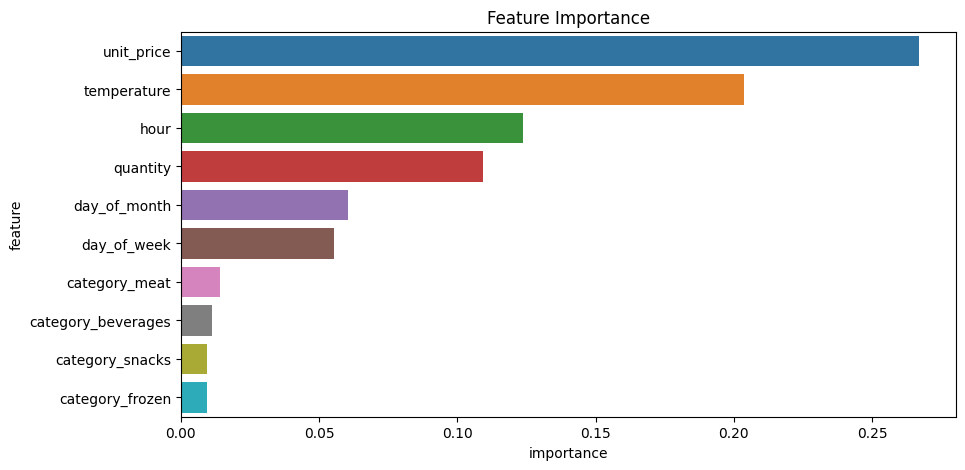

In [53]:
# plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Feature Importance')
plt.show()

This feature importance visualisation tells us:

- The product categories were not that important
- The unit price and temperature were important in predicting stock
- The hour of day was also important for predicting stock